In [1]:
import pandas
import warnings

warnings.simplefilter('ignore')

researched_country = 'Poland'

arrivals2020 = pandas.read_csv('raw_data/raw_arrivals_data/arrivals_2020.csv')
arrivals2021 = pandas.read_csv('raw_data/raw_arrivals_data/arrivals_2021.csv')

arrivals_data = arrivals2020.append(arrivals2021, ignore_index=True)


arrivals_data = arrivals_data.filter(["FLT_DATE", "APT_NAME", "STATE_NAME", "FLT_ARR_1", "APT_ICAO"])

arrivals_data = arrivals_data.drop(arrivals_data[arrivals_data['STATE_NAME'] != researched_country].index)

EPKT_RAW = arrivals_data.drop(arrivals_data[arrivals_data['APT_ICAO'] != 'EPKT'].index)
EPWA_RAW = arrivals_data.drop(arrivals_data[arrivals_data['APT_ICAO'] != 'EPWA'].index)
EPMO_RAW = arrivals_data.drop(arrivals_data[arrivals_data['APT_ICAO'] != 'EPMO'].index)

def aggregate(arrivals_data):
    data_arrival_dict = dict()

    for index, row in arrivals_data.iterrows():
        date = row['FLT_DATE'][0:10]
        arrivals = row["FLT_ARR_1"]
        if date in data_arrival_dict:
            data_arrival_dict[date] += arrivals
        else:
            data_arrival_dict[date] = arrivals

    arrivals_data = pandas.DataFrame(data_arrival_dict.items(), columns=['date', 'arrivals'])

    arrivals_data['date'] = pandas.to_datetime(arrivals_data['date'])
    return arrivals_data


EPWA = aggregate(EPWA_RAW)
EPKT = aggregate(EPKT_RAW)
EPMO = aggregate(EPMO_RAW)

EPKT


,date,arrivals
0,2020-01-01,29
1,2020-01-02,47
2,2020-01-03,44
3,2020-01-04,41
4,2020-01-05,48
...,...,...
663,2021-10-27,40
664,2021-10-28,41
665,2021-10-29,39
666,2021-10-30,36


In [7]:
# import seaborn as sns
# sns.set_theme()
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

rolling_window = 7

EPWA_smooth = EPWA
EPWA_smooth['arrivals'] = EPWA_smooth['arrivals'].rolling(rolling_window).mean().fillna(method='bfill')
EPWA_smooth = EPWA_smooth.rename(columns={'arrivals' : 'EPWA'})

EPKT_smooth = EPKT
EPKT_smooth['arrivals'] = EPKT_smooth['arrivals'].rolling(rolling_window).mean().fillna(method='bfill')
EPKT_smooth = EPKT_smooth.rename(columns={'arrivals' : 'EPKT'})

EPMO_smooth = EPMO
EPMO_smooth['arrivals'] = EPMO_smooth['arrivals'].rolling(rolling_window).mean().fillna(method='bfill')
EPMO_smooth = EPMO_smooth.rename(columns={'arrivals' : 'EPMO'})

merged = EPWA_smooth.merge(EPKT_smooth.merge(EPMO_smooth, on='date'), on='date')

# ax1 = merged.plot(x = 'date', ylabel = 'daily arrivals', figsize=(20, 10))



In [8]:
covid_data = pandas.read_csv('raw_data/covid_data_raw.csv')
covid_data = covid_data.filter(['location', 'date', 'new_cases'])
covid_data = covid_data.drop(covid_data[covid_data['location'] != researched_country].index)
covid_data['new_cases'] = covid_data['new_cases'].astype(int)
covid_data['date'] = pandas.to_datetime(covid_data['date'])

covid_data = covid_data.drop(covid_data[covid_data['date'] > EPWA['date'].iat[-1]].index)
covid_data['new_cases'] = covid_data['new_cases'].rolling(rolling_window).mean().fillna(method='bfill')

final_data = merged.merge(covid_data, on='date')
final_data = final_data.drop('location', 1)

<AxesSubplot:xlabel='date', ylabel='new_cases'>

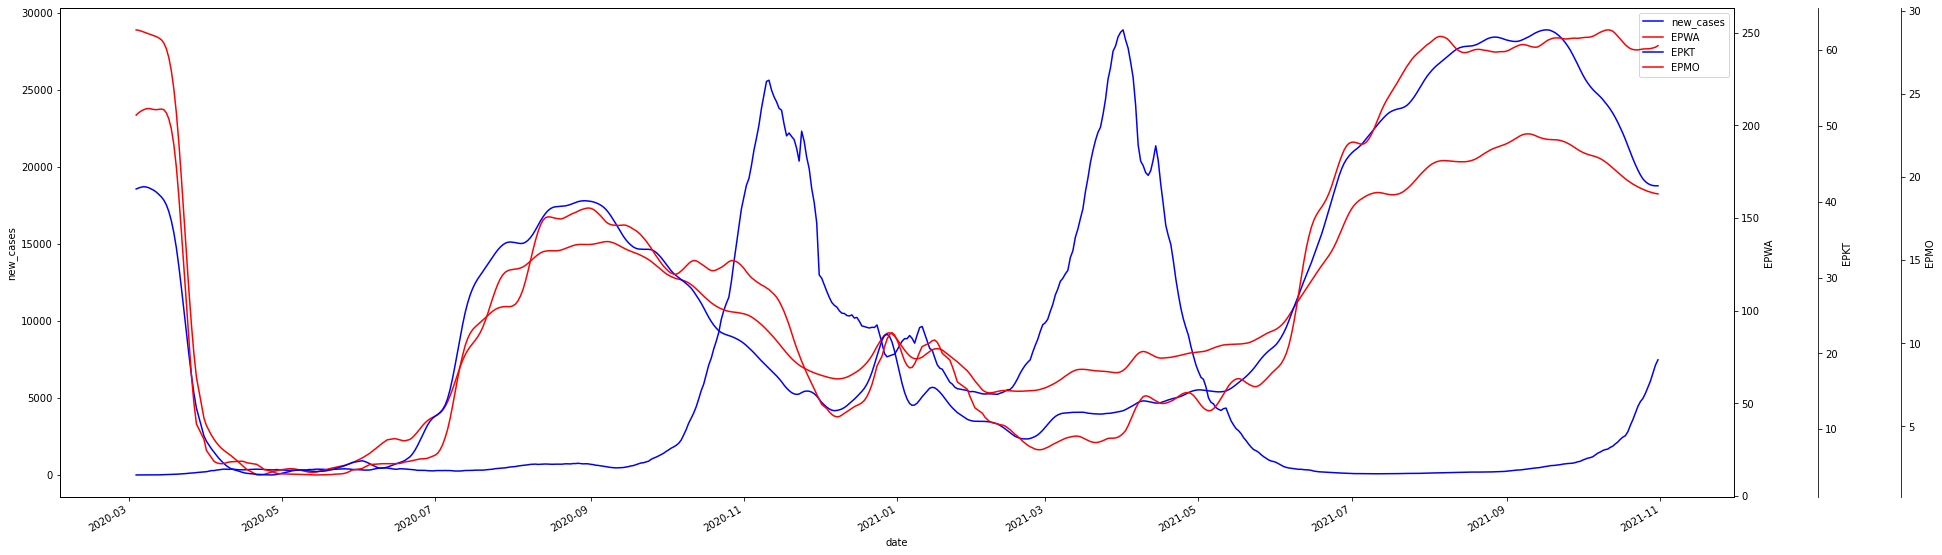

In [9]:
from typing import List, Union

import matplotlib.axes
import pandas as pd

def plot_multi(
    data: pd.DataFrame,
    x: Union[str, None] = None,
    y: Union[List[str], None] = None,
    spacing: float = 0.1,
    **kwargs
) -> matplotlib.axes.Axes:
    
    from pandas.plotting._matplotlib.style import get_standard_colors

    # Get default color style from pandas - can be changed to any other color list
    if y is None:
        y = data.columns

    # remove x_col from y_cols
    if x:
        y = [col for col in y if col != x]

    if len(y) == 0:
        return
    # colors = get_standard_colors(num_colors=len(y))
    # colors = ['black', 'red', 'green', 'blue']
    colors = ['blue', 'red']

    if "legend" not in kwargs:
        kwargs["legend"] = False  # prevent multiple legends

    # First axis
    # ax = data.plot(x=x, y=y[0], color=colors[0],linestyle='dashed', linewidth=3, **kwargs)
    ax = data.plot(x=x, y=y[0], color=colors[0], **kwargs)

    ax.set_ylabel(ylabel=y[0])
    lines, labels = ax.get_legend_handles_labels()

    for i in range(1, len(y)):
        # Multiple y-axes
        ax_new = ax.twinx()
        ax_new.spines["right"].set_position(("axes", 1 + spacing * (i - 1)))
        data.plot(
            ax=ax_new, x=x, y=y[i], color=colors[i % len(colors)], **kwargs
        )
        ax_new.set_ylabel(ylabel=y[i])

        # Proper legend position
        line, label = ax_new.get_legend_handles_labels()
        lines += line
        labels += label

    ax.legend(lines, labels, loc=0)
    return ax

plot_multi(final_data, x='date', y='new_cases EPWA EPKT EPMO'.split(), figsize=(30, 10), spacing=0.05)

<AxesSubplot:xlabel='date', ylabel='new_cases'>

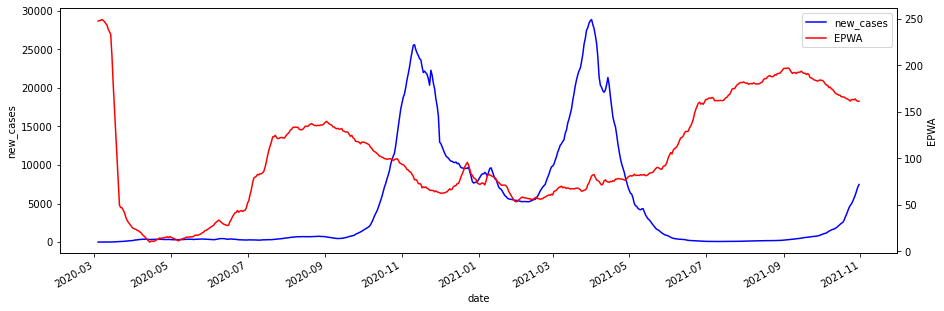

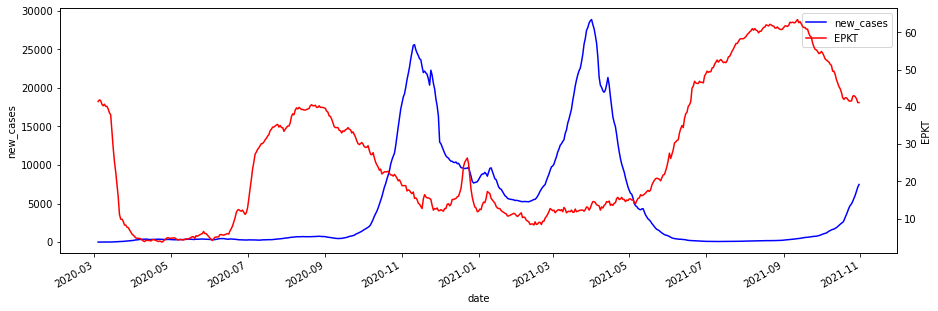

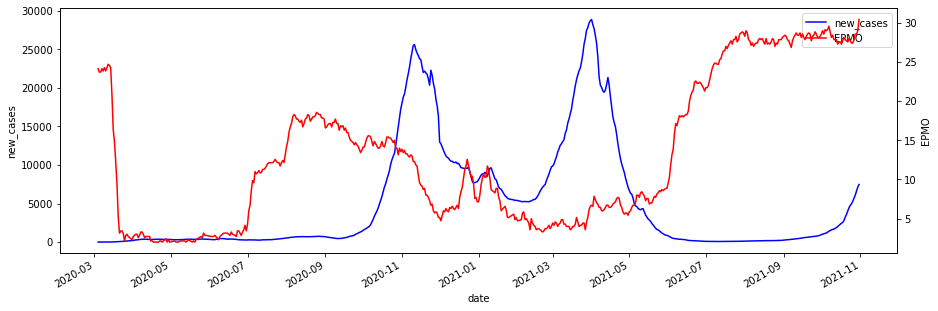

In [5]:

plot_multi(final_data.drop('EPKT', 1).drop('EPMO', 1), x='date', y=['new_cases', 'EPWA'], figsize=(15,5))
plot_multi(final_data.drop('EPWA', 1).drop('EPMO', 1), x='date', y=['new_cases', 'EPKT'], figsize=(15,5))
plot_multi(final_data.drop('EPWA', 1).drop('EPKT', 1), x='date', y=['new_cases', 'EPMO'], figsize=(15,5))
